In [62]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [46]:
unr_idd_df_path = '/Users/syedreehan/Desktop/UNR-IDD.csv'  # Update the path accordingly
unsw_nb15_df_path = '/Users/syedreehan/Desktop/unsw.csv'  # Update the path accordingly
unr_idd_df = pd.read_csv(unr_idd_df_path)
unsw_nb15_df = pd.read_csv(unsw_nb15_df_path)


In [47]:
unr_idd_df.head()

,Switch ID,Port Number,Received Packets,Received Bytes,Sent Bytes,Sent Packets,Port alive Duration (S),Packets Rx Dropped,Packets Tx Dropped,Packets Rx Errors,...,Unknown Load/Latest,Latest bytes counter,is_valid,Table ID,Active Flow Entries,Packets Looked Up,Packets Matched,Max Size,Label,Binary Label
0,of:000000000000000c,Port#:1,132,9181,6311853,238,46,0,0,0,...,0,0,True,0,9,767,688,-1,TCP-SYN,Attack
1,of:000000000000000c,Port#:2,187,6304498,15713,171,46,0,0,0,...,0,0,True,0,9,767,688,-1,TCP-SYN,Attack
2,of:000000000000000c,Port#:3,235,6311567,8030,58,46,0,0,0,...,0,0,True,0,9,767,688,-1,TCP-SYN,Attack
3,of:000000000000000c,Port#:4,59,7878,16439,182,46,0,0,0,...,0,0,True,0,9,767,688,-1,TCP-SYN,Attack
4,of:000000000000000a,Port#:1,188,6304547,16497,183,46,0,0,0,...,0,0,True,0,7,489,403,-1,TCP-SYN,Attack


In [48]:
unsw_nb15_df.head()

,scrip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,59.166.0.0,52487,149.171.126.4,80,tcp,FIN,1.005723,1684,10168,31,...,0,2,1,1,1,1,1,1,NaN,0
1,59.166.0.4,35558,149.171.126.4,53,udp,CON,0.001020,130,162,31,...,0,1,1,1,3,1,1,1,NaN,0
2,175.45.176.0,3656,149.171.126.18,1723,tcp,FIN,0.632365,1332,268,254,...,0,5,3,1,1,1,1,1,Fuzzers,1
3,59.166.0.0,28986,149.171.126.0,53,udp,CON,0.001045,146,178,31,...,0,3,5,3,2,2,1,2,NaN,0
4,59.166.0.9,56654,149.171.126.5,80,tcp,FIN,0.004036,1044,824,31,...,0,3,1,4,10,2,1,1,NaN,0


In [49]:
# Align the Labels for UNR-IDD dataset
unr_idd_df['label'] = np.where(unr_idd_df['Binary Label'] == "Attack", 1, 0)

# Feature Selection and Alignment
# UNR-IDD
unr_idd_selected = unr_idd_df[['Received Bytes', 'Sent Bytes', 'Received Packets', 'Sent Packets', 'label']]
unr_idd_selected.columns = ['dbytes', 'sbytes', 'dpkts', 'spkts', 'label']

# UNSW-NB15
unsw_nb15_selected = unsw_nb15_df[['sbytes', 'dbytes', 'spkts', 'dpkts', 'Label']]
unsw_nb15_selected.columns = ['sbytes', 'dbytes', 'spkts', 'dpkts', 'label']

# Concatenate the datasets
combined_df = pd.concat([unr_idd_selected, unsw_nb15_selected], ignore_index=True)

# Check for and handle missing values (if any)
# In this case, no missing values were found

# Normalize the numerical features
scaler = MinMaxScaler()
numerical_columns = ['sbytes', 'dbytes', 'spkts', 'dpkts']
combined_df[numerical_columns] = scaler.fit_transform(combined_df[numerical_columns])


In [50]:
combined_df.head()

,dbytes,sbytes,dpkts,spkts,label
0,0.000034,0.026382,0.000374,0.000562,1
1,0.023213,0.000066,0.000530,0.000403,1
2,0.023239,0.000033,0.000666,0.000135,1
3,0.000029,0.000069,0.000167,0.000429,1
4,0.023213,0.000069,0.000533,0.000432,1


In [51]:
sns.set_style("whitegrid")

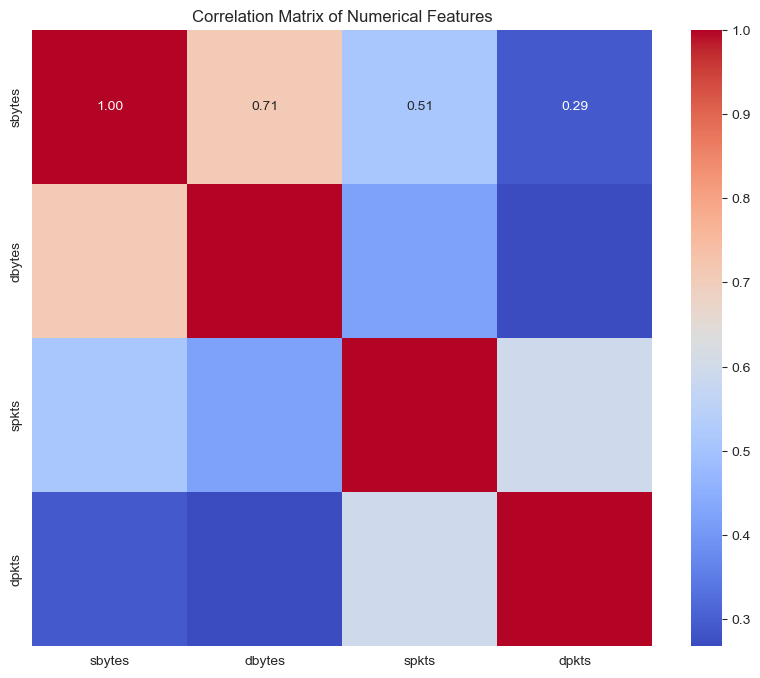

In [52]:
plt.figure(figsize=(10, 8))
corr = combined_df[['sbytes', 'dbytes', 'spkts', 'dpkts']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

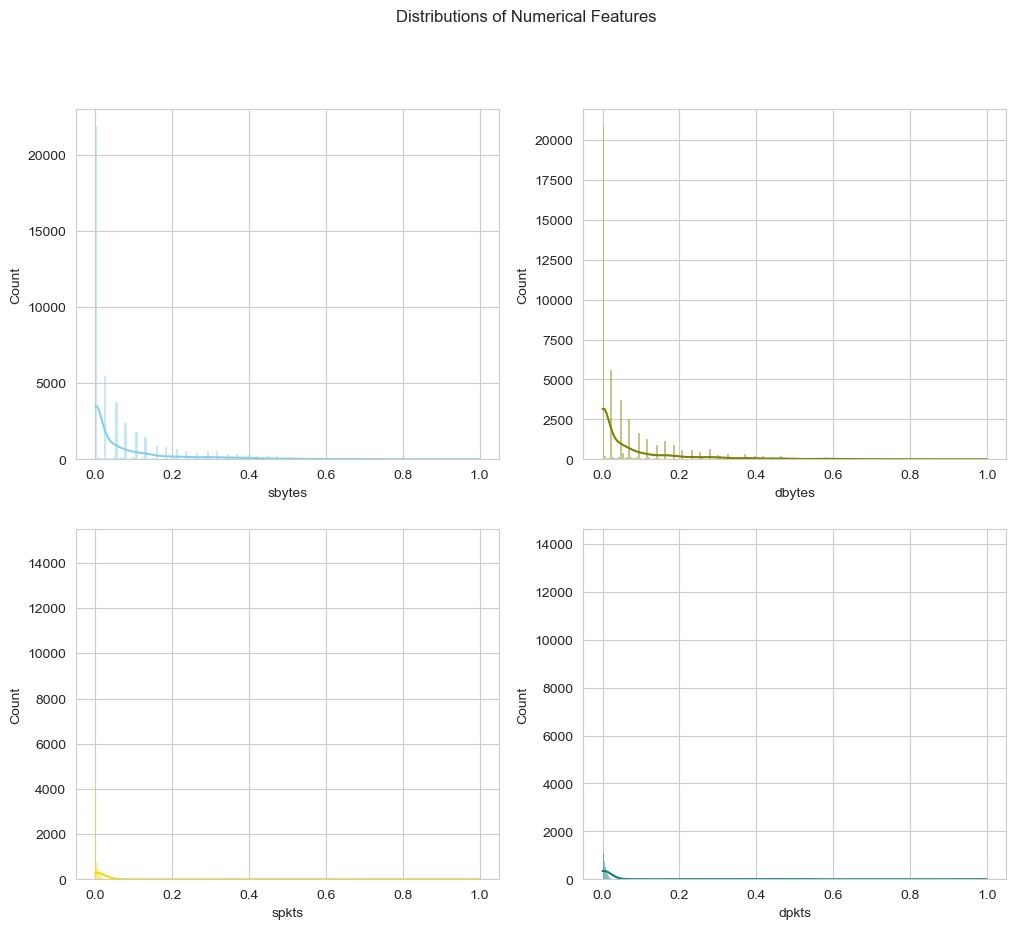

In [53]:
# Feature Distributions
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Distributions of Numerical Features')
sns.histplot(data=combined_df, x='sbytes', kde=True, ax=axs[0, 0], color="skyblue")
sns.histplot(data=combined_df, x='dbytes', kde=True, ax=axs[0, 1], color="olive")
sns.histplot(data=combined_df, x='spkts', kde=True, ax=axs[1, 0], color="gold")
sns.histplot(data=combined_df, x='dpkts', kde=True, ax=axs[1, 1], color="teal")
plt.show()

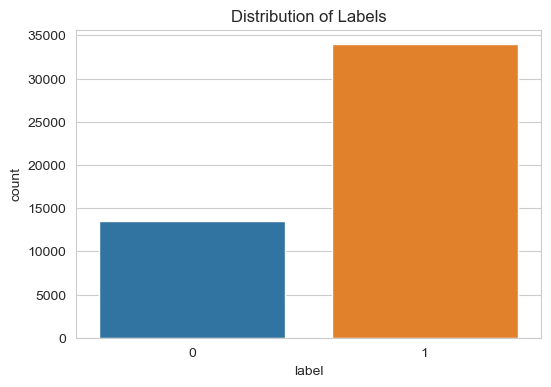

In [54]:
# Label Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=combined_df)
plt.title('Distribution of Labels')
plt.show()

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Splitting the dataset into training and testing sets
X = combined_df.drop('label', axis=1)
y = combined_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing and training the Random Forest classifier
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Making predictions
predictions_rf = model_rf.predict(X_test)

# Evaluating the model
print(confusion_matrix(y_test, predictions_rf))
print(classification_report(y_test, predictions_rf))


[[2649   16]
 [  17 6801]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2665
           1       1.00      1.00      1.00      6818

    accuracy                           1.00      9483
   macro avg       1.00      1.00      1.00      9483
weighted avg       1.00      1.00      1.00      9483



In [57]:
# Training the SVM model
model_svm = SVC(probability=True, random_state=42)  # Probability=True for ROC AUC Score calculation
model_svm.fit(X_train, y_train)

# Predictions
predictions_svm = model_svm.predict(X_test)
probabilities_svm = model_svm.predict_proba(X_test)[:, 1]


In [58]:
# Evaluating the SVM model
print("SVM Confusion Matrix:")
print(confusion_matrix(y_test, predictions_svm))
print("\nSVM Classification Report:")
print(classification_report(y_test, predictions_svm))
print("SVM ROC AUC Score:", roc_auc_score(y_test, probabilities_svm))

# Calculating ROC Curve for SVM
fpr_svm, tpr_svm, _ = roc_curve(y_test, probabilities_svm)

SVM Confusion Matrix:
[[2665    0]
 [1216 5602]]

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.69      1.00      0.81      2665
           1       1.00      0.82      0.90      6818

    accuracy                           0.87      9483
   macro avg       0.84      0.91      0.86      9483
weighted avg       0.91      0.87      0.88      9483

SVM ROC AUC Score: 0.9748181202280466


In [59]:
# Repeat evaluation for Random Forest for comparison
predictions_rf = model_rf.predict(X_test)
probabilities_rf = model_rf.predict_proba(X_test)[:, 1]

print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, predictions_rf))
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, predictions_rf))
print("Random Forest ROC AUC Score:", roc_auc_score(y_test, probabilities_rf))

Random Forest Confusion Matrix:
[[2649   16]
 [  17 6801]]

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2665
           1       1.00      1.00      1.00      6818

    accuracy                           1.00      9483
   macro avg       1.00      1.00      1.00      9483
weighted avg       1.00      1.00      1.00      9483

Random Forest ROC AUC Score: 0.9995731693558108


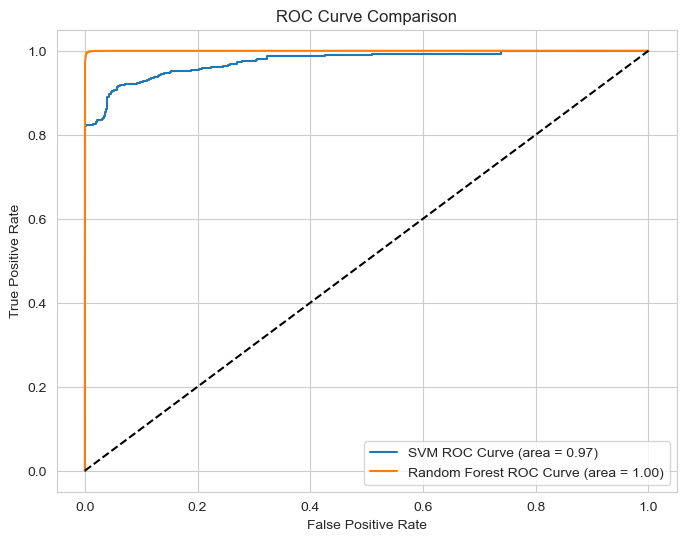

In [60]:
# Calculating ROC Curve for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, probabilities_rf)

# Plotting ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label='SVM ROC Curve (area = %0.2f)' % roc_auc_score(y_test, probabilities_svm))
plt.plot(fpr_rf, tpr_rf, label='Random Forest ROC Curve (area = %0.2f)' % roc_auc_score(y_test, probabilities_rf))
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.show()


In [66]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score

# Set MLflow tracking URI and initialize MLflow experiment
mlflow.set_tracking_uri("http://0.0.0.0:5001")
mlflow.set_experiment("Random_Forest_Experiments")

# Define parameters for the experiment
params = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10]
}

# Maximum number of runs limit
max_runs = 10

# Load and prepare your dataset here
# X, y = load_your_data()

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

run_counter = 1  # Initialize run counter

for n_estimators in params["n_estimators"]:
    if run_counter > max_runs:  # Check if maximum number of runs reached
        print("Maximum number of runs reached.")
        break
    for max_depth in params["max_depth"]:
        if run_counter > max_runs:  # Check if maximum number of runs reached
            break
        for min_samples_split in params["min_samples_split"]:
            if run_counter > max_runs:  # Check if maximum number of runs reached
                break
            run_name = f"Run {run_counter}"  # Custom run name
            with mlflow.start_run(run_name=run_name):
                # Train the model
                model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
                model.fit(X_train, y_train)
                
                # Making predictions
                predictions = model.predict(X_test)
                
                # Calculating metrics
                auc_score = roc_auc_score(y_test, predictions)
                accuracy = accuracy_score(y_test, predictions)
                precision = precision_score(y_test, predictions)
                recall = recall_score(y_test, predictions)

                # Logging parameters and metrics
                mlflow.log_params({"n_estimators": n_estimators, "max_depth": max_depth, "min_samples_split": min_samples_split})
                mlflow.log_metric("roc_auc", auc_score)
                mlflow.log_metric("accuracy", accuracy)
                mlflow.log_metric("precision", precision)
                mlflow.log_metric("recall", recall)

                # Logging the model
                mlflow.sklearn.log_model(model, "random_forest_model")
                
                print(f"{run_name} with n_estimators={n_estimators}, max_depth={max_depth}, min_samples_split={min_samples_split}, AUC={auc_score}, Accuracy={accuracy}, Precision={precision}, Recall={recall}")
                
                run_counter += 1  # Increment run counter


2024/04/01 06:02:42 INFO mlflow.tracking.fluent: Experiment with name 'Random_Forest_Experiments' does not exist. Creating a new experiment.


Run 1 with n_estimators=100, max_depth=None, min_samples_split=2, AUC=0.9957514239153945, Accuracy=0.9965200885795634, Precision=0.9976529265072612, Recall=0.9975066001760047
Run 2 with n_estimators=100, max_depth=None, min_samples_split=5, AUC=0.9953438007877835, Accuracy=0.996098281134662, Precision=0.997505502567865, Recall=0.9970665884423585
Run 3 with n_estimators=100, max_depth=None, min_samples_split=10, AUC=0.9951885721330305, Accuracy=0.9962037329958874, Precision=0.9972140762463343, Recall=0.9975066001760047
Run 4 with n_estimators=100, max_depth=10, min_samples_split=2, AUC=0.9917790728328116, Accuracy=0.9940946957713803, Precision=0.9947322212467077, Recall=0.9970665884423585
Run 5 with n_estimators=100, max_depth=10, min_samples_split=5, AUC=0.9913628916283296, Accuracy=0.993989243910155, Precision=0.9942974119023249, Recall=0.9973599295981226
Run 6 with n_estimators=100, max_depth=10, min_samples_split=10, AUC=0.9911428857615066, Accuracy=0.9936728883264789, Precision=0.9